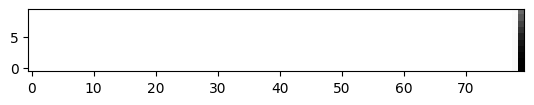

In [11]:
from scipy.stats import multivariate_normal
test = np.zeros(n_particles)
center = [400, 0]

for x in np.arange(Nx):
    for y in np.arange(Ny):
        test[x+y*Nx] = multivariate_normal.pdf([x,y], mean = center, cov = [[100, 0], [0, 100]])
test = einops.rearrange(test, "(y x) -> x y", y=Ny).transpose()
test = test / test.max() * 9000
plt.imshow(test, origin = 'lower', cmap='Greys')
plt.show()

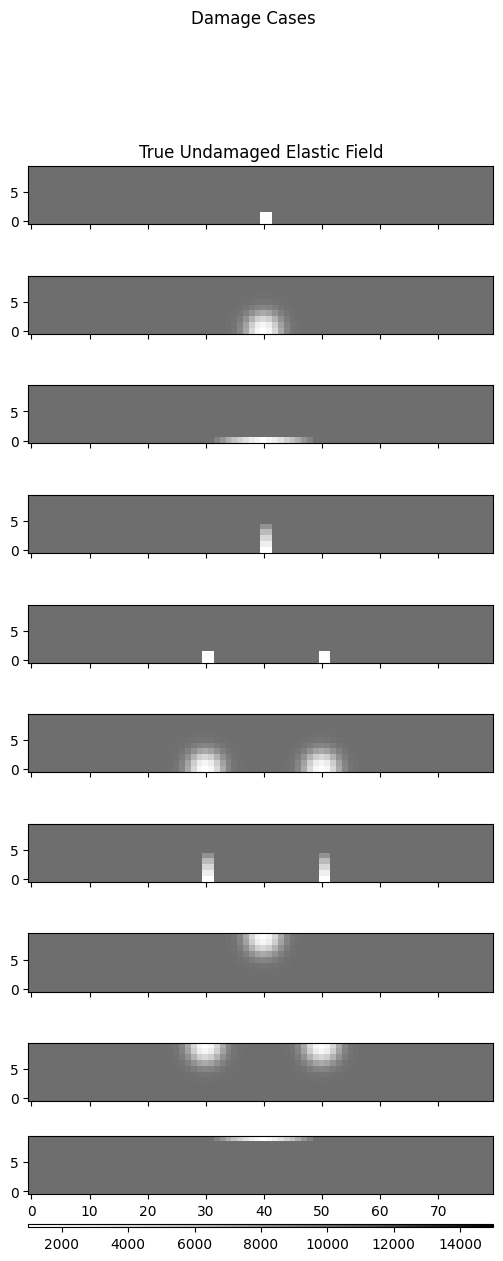

In [9]:
import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import multivariate_normal

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]


filenames_1e4 = []
for name in filenames:
    if '10000' in name:
        filenames_1e4.append(name)



E_hists = []
results = []
avg_err = []
avg_err_damaged = []


Nx = 80
Ny = 10
n_particles = Nx * Ny

E_d = np.zeros(n_particles)
E_g = np.zeros(n_particles)
E_h = np.zeros(n_particles)
E_v = np.zeros(n_particles)
E_d_m = np.zeros(n_particles)
E_g_m = np.zeros(n_particles)
E_v_m = np.zeros(n_particles)
E_gt = np.zeros(n_particles) + 10000
E_gt_m = np.zeros(n_particles) + 10000
E_ht = np.zeros(n_particles) + 10000

for i in range(n_particles):
    col = i % Nx
    E_d[i] = 10000
    E_g[i] = 10000
    E_h[i] = 10000
    E_v[i] = 10000
    E_d_m[i] = 10000
    E_g_m[i] = 10000
    E_v_m[i] = 10000

def discrete_damage(left, width, height):
    idx = np.array([])
    for row in np.arange(height):
        idx = np.concatenate((idx, np.arange(left+Nx*row, left+width+Nx*row)))
    
    return [int(i) for i in idx]

def gradient_damage(E, start, width, half_length, horizontal=True, E_start=1000, E_stop=10000):
    interp = np.interp(np.arange(half_length), [0, half_length-1], [E_start, E_stop])
    if horizontal:
        for row in np.arange(width):
            E[np.arange(start+Nx*row, start+half_length+Nx*row)] = interp
            E[np.arange(start+Nx*row, start-half_length+Nx*row, -1)] = interp
    else:
        for col in np.arange(width):
            E[np.arange(start+col, start+col+half_length*Nx, Nx)] = interp

def gaussian_damage(E, center, start=9000, cov=[[4, 0], [0, 4]]):
    x, y = np.meshgrid(np.arange(Nx), np.arange(Ny))
    coords = np.column_stack([x.ravel(), y.ravel()])

    dmg = multivariate_normal.pdf(coords, mean=center, cov=cov)
    dmg = dmg.reshape(E.shape)
    
    dmg = dmg / dmg.max() * start
    E = E - dmg
    return E

E_d_damage_idx = discrete_damage(40, 2, 2)
E_d[E_d_damage_idx] = np.repeat(1000, len(E_d_damage_idx))

E_d_m_damage_idx = np.concatenate((discrete_damage(30, 2, 2), discrete_damage(50, 2, 2)))
E_d_m[E_d_m_damage_idx] = np.repeat(1000, len(E_d_m_damage_idx))

gradient_damage(E_h, 40, 1, 10)
gradient_damage(E_ht, 760, 1, 10)

gradient_damage(E_v, 40, 2, 6, horizontal=False)
gradient_damage(E_v_m, 30, 2, 6, horizontal=False)
gradient_damage(E_v_m, 50, 2, 6, horizontal=False)

E_g = gaussian_damage(E_g, [40, 0])
E_g_m = gaussian_damage(E_g_m, [30, 0])
E_g_m = gaussian_damage(E_g_m, [50, 0])
E_gt = gaussian_damage(E_gt, [40, 9])
E_gt_m = gaussian_damage(E_gt_m, [30, 9])
E_gt_m = gaussian_damage(E_gt_m, [50, 9])

E_d = einops.rearrange(E_d, "(y x) -> x y", y=Ny).transpose()
E_g = einops.rearrange(E_g, "(y x) -> x y", y=Ny).transpose()
E_h = einops.rearrange(E_h, "(y x) -> x y", y=Ny).transpose()
E_v = einops.rearrange(E_v, "(y x) -> x y", y=Ny).transpose()
E_d_m = einops.rearrange(E_d_m, "(y x) -> x y", y=Ny).transpose()
E_g_m = einops.rearrange(E_g_m, "(y x) -> x y", y=Ny).transpose()
E_v_m = einops.rearrange(E_v_m, "(y x) -> x y", y=Ny).transpose()
E_gt = einops.rearrange(E_gt, "(y x) -> x y", y=Ny).transpose()
E_gt_m = einops.rearrange(E_gt_m, "(y x) -> x y", y=Ny).transpose()
E_ht = einops.rearrange(E_ht, "(y x) -> x y", y=Ny).transpose()

fig, axs = plt.subplots(10,1, sharex=True, sharey=True, figsize=(6,14))


fig.suptitle('Damage Cases')

axs[0].imshow(E_d, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
axs[0].set_title('True Undamaged Elastic Field')

axs[1].imshow(E_g, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[1].set_title('True Damaged Elastic Field')

axs[2].imshow(E_h, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[2].set_title('True Damaged Elastic Field')

axs[3].imshow(E_v, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[3].set_title('True Damaged Elastic Field')

axs[4].imshow(E_d_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[4].set_title('True Damaged Elastic Field')

axs[5].imshow(E_g_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[5].set_title('True Damaged Elastic Field')

axs[6].imshow(E_v_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[6].set_title('True Damaged Elastic Field')

axs[7].imshow(E_gt, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[8].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


im = axs[9].imshow(E_ht, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
divider = make_axes_locatable(axs[9])
cax = divider.append_axes("bottom", size="5%", pad=0.3)
fig.colorbar(im, cax=cax, orientation='horizontal')

# im1 = axs[2, 0].imshow(E_sensor, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
# axs[2, 0].set_title('Estimated Undamaged Field, Discrete Surface Observability')
# divider1 = make_axes_locatable(axs[2, 0])
# cax1 = divider1.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im1, cax=cax1, orientation='horizontal')

# im2 = axs[2, 1].imshow(E_sensor_damaged, origin='lower', cmap='Greys', vmin=5000, vmax = 15000)
# axs[2, 1].set_title('Estimated Damaged Field, Discrete Surface Observability')
# divider2 = make_axes_locatable(axs[2, 1])
# cax2 = divider2.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im2, cax=cax2, orientation='horizontal')
plt.show()
    

    


result_dm_80_10_full.json


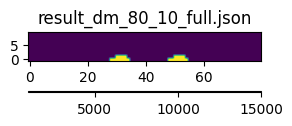

result_dm_80_10_row.json


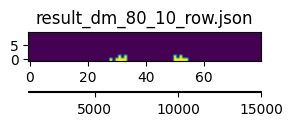

result_dm_80_10_sensor.json


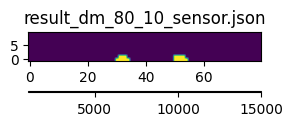

result_d_80_10_full.json


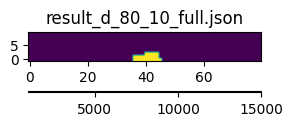

result_d_80_10_row.json


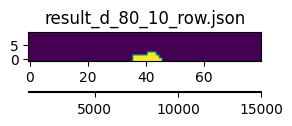

result_d_80_10_sensor.json


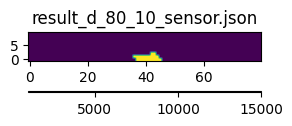

result_gm_80_10_full.json


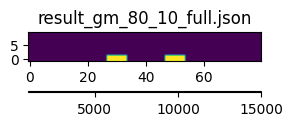

result_gm_80_10_row.json


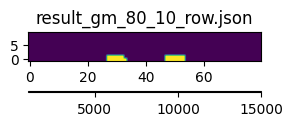

result_gm_80_10_sensor.json


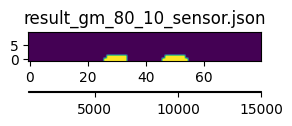

result_gtm_80_10_full.json


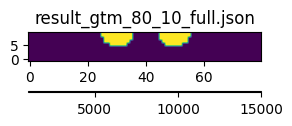

result_gtm_80_10_row.json


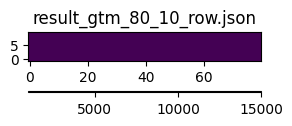

result_gtm_80_10_sensor.json


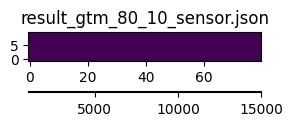

result_gt_80_10_full.json


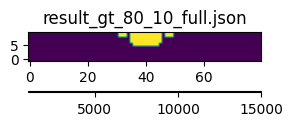

result_gt_80_10_row.json


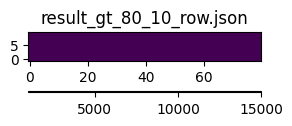

result_gt_80_10_sensor.json


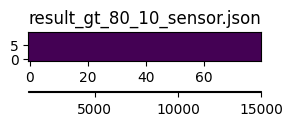

result_g_80_10_full.json


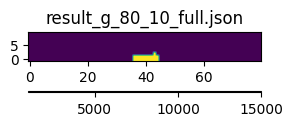

result_g_80_10_row.json


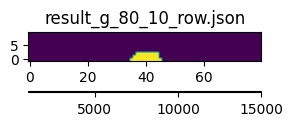

result_g_80_10_sensor.json


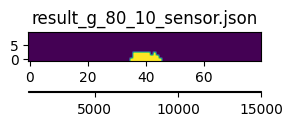

result_ht_80_10_full.json


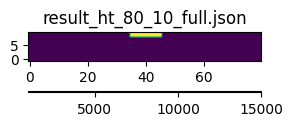

result_ht_80_10_row.json


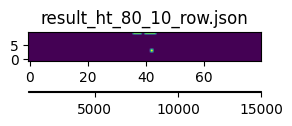

result_ht_80_10_sensor.json


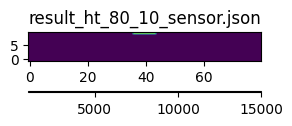

result_h_80_10_full.json


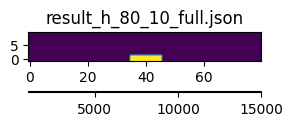

result_h_80_10_row.json


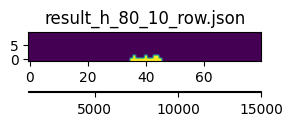

result_h_80_10_sensor.json


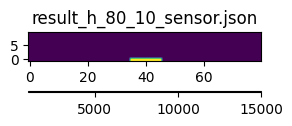

result_vm_80_10_full.json


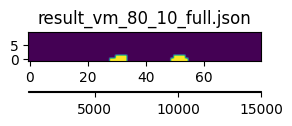

result_vm_80_10_row.json


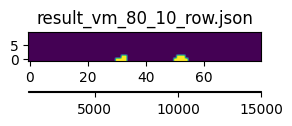

result_vm_80_10_sensor.json


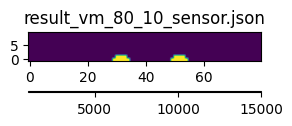

result_v_80_10_full.json


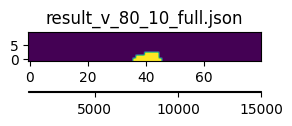

result_v_80_10_row.json


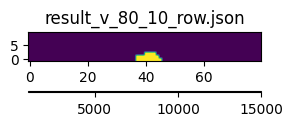

result_v_80_10_sensor.json


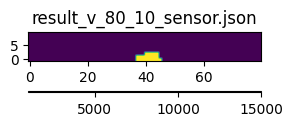

In [11]:
import json, os, re
import numpy as np
import matplotlib.pyplot as plt
import einops
from mpl_toolkits.axes_grid1 import make_axes_locatable

directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]
filenames2 = []
for file in filenames:
    if "mask" not in file:
        filenames2.append(file)
filenames = filenames2

E_hists = []
results = []
avg_err = []
avg_err_damaged = []


Nx = 80
Ny = 10
n_particles = Nx * Ny
E_true = np.zeros(n_particles)
E_damaged = np.zeros(n_particles)

pattern = r"_(\d+)_(\d+)_"

def stable_regions(x, reference, n_percent=10, m=2):
    deviation = (x - reference) ** 2
    n_elements = int(len(deviation) * (n_percent / 100))
    
    # Get indices of the lowest n% deviations
    stable_indices = np.argsort(deviation)[:n_elements]
    
    # Compute the standard deviation of these stable elements
    stable_std = np.std(deviation[stable_indices])
    
    # Identify indices where deviation exceeds m times the stable standard deviation
    threshold = m * stable_std
    exceed_indices = np.where(deviation > threshold)[0]

    return stable_indices, stable_std, exceed_indices

for name in filenames:
    print(name)
    with open(name) as json_file:
        result = json.load(json_file)['E_hist'][-1]   
    E = np.zeros(n_particles)
    match = re.search(pattern, name)
    n_blocks_x = int(match.group(1))
    n_blocks_y = int(match.group(2))
    n_blocks = n_blocks_y * n_blocks_x
    block_nx = int(Nx / n_blocks_x)
    block_ny = int(Ny / n_blocks_y)

    for i in range(Nx):
        for j in range(Ny):
            block_index_x = i // block_nx
            block_index_y = j // block_ny
            E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
    E = einops.rearrange(E, "(y x) -> x y", y=Ny)#.transpose()
    
    obs = re.search("_([a-z]+).json", name).group(1)


    fig, axs = plt.subplots(1,1,figsize=(3,1))
    # title = str(n_blocks_x) + ' by ' + str(n_blocks_y) + ", " + obs + " observability"
    title = name


    im = axs.imshow(E.transpose(), origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
    axs.set_title(title)
    divider= make_axes_locatable(axs)
    cax= divider.append_axes("bottom", size="5%", pad=0.3)
    fig.colorbar(im, cax=cax, orientation='horizontal')


    table, std, exceed = stable_regions(np.array(result), 1e4, n_percent=50, m=1e3)
    mask = np.zeros(n_particles)
    mask[exceed] = 100
    mask = einops.rearrange(mask, "(y x) -> x y", y=Ny).transpose()

    axs.imshow(mask, origin='lower')

    plt.show()
        

    


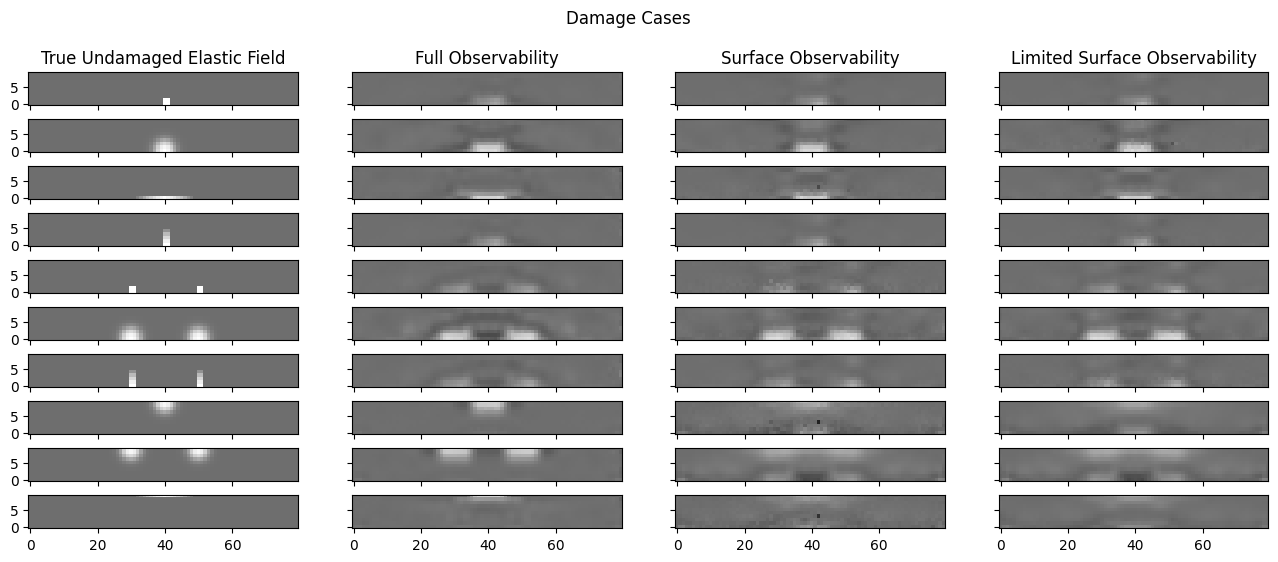

In [22]:
fig, axs = plt.subplots(10,4, sharex=True, sharey=True, figsize=(16,6))


fig.suptitle('Damage Cases')

axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
axs[0, 0].set_title('True Undamaged Elastic Field')

axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


im = axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']


directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]



Nx = 80
Ny = 10
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

for k, case in enumerate(cases):
    obs_cases = [
        'result_'+case+'_80_10_full.json',
        'result_'+case+'_80_10_row.json',
        'result_'+case+'_80_10_sensor.json'
    ]
    for l, obs_case in enumerate(obs_cases):
        with open(obs_case) as json_file:
            result = json.load(json_file)['E_hist'][-1]   
        E = np.zeros(n_particles)
        match = re.search(pattern, name)
        n_blocks_x = int(match.group(1))
        n_blocks_y = int(match.group(2))
        n_blocks = n_blocks_y * n_blocks_x
        block_nx = int(Nx / n_blocks_x)
        block_ny = int(Ny / n_blocks_y)

        for i in range(Nx):
            for j in range(Ny):
                block_index_x = i // block_nx
                block_index_y = j // block_ny
                E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
        E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
        
        axs[k, l + 1].imshow(E, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[0, 1].set_title('Full Observability')
axs[0, 2].set_title('Surface Observability')
axs[0, 3].set_title('Limited Surface Observability')
plt.show()
    

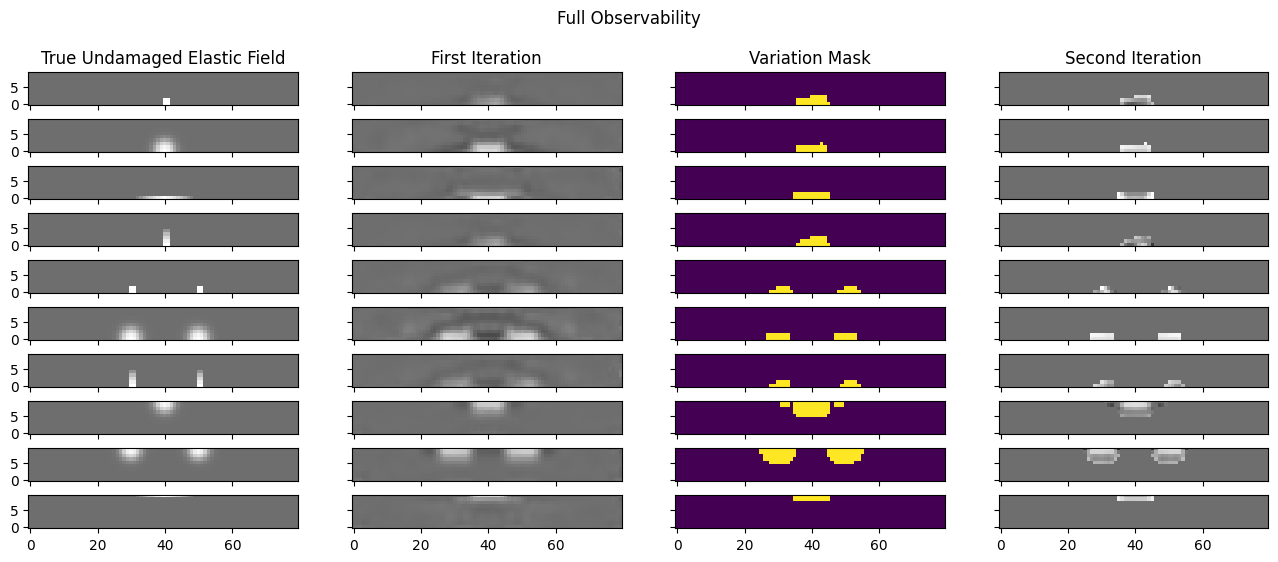

In [21]:
fig, axs = plt.subplots(10,4, sharex=True, sharey=True, figsize=(16,6))


fig.suptitle('Full Observability')

axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
axs[0, 0].set_title('True Undamaged Elastic Field')

axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


im = axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']


directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]



Nx = 80
Ny = 10
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

def stable_regions(x, reference, n_percent=10, m=2):
    deviation = (x - reference) ** 2
    n_elements = int(len(deviation) * (n_percent / 100))
    
    # Get indices of the lowest n% deviations
    stable_indices = np.argsort(deviation)[:n_elements]
    
    # Compute the standard deviation of these stable elements
    stable_std = np.std(deviation[stable_indices])
    
    # Identify indices where deviation exceeds m times the stable standard deviation
    threshold = m * stable_std
    exceed_indices = np.where(deviation > threshold)[0]

    return stable_indices, stable_std, exceed_indices


for k, case in enumerate(cases):
    obs_cases = [
        'result_'+case+'_80_10_full.json',
    ]
    for l, obs_case in enumerate(obs_cases):
        with open(obs_case) as json_file:
            result = json.load(json_file)['E_hist'][-1]   
        E = np.zeros(n_particles)
        match = re.search(pattern, name)
        n_blocks_x = int(match.group(1))
        n_blocks_y = int(match.group(2))
        n_blocks = n_blocks_y * n_blocks_x
        block_nx = int(Nx / n_blocks_x)
        block_ny = int(Ny / n_blocks_y)

        for i in range(Nx):
            for j in range(Ny):
                block_index_x = i // block_nx
                block_index_y = j // block_ny
                E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
        E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
        
        axs[k, l + 1].imshow(E, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

    stable, std, exceed = stable_regions(np.array(result), 1e4, n_percent=50, m=1e3)
    mask = np.zeros(n_particles)
    mask[exceed] = 100
    mask = einops.rearrange(mask, "(y x) -> x y", y=Ny).transpose()
    axs[k, l + 2].imshow(mask, origin='lower')
    
    it2 = 'result_'+case+'_mask_80_10_full_start_100.0.json'
    with open(it2) as json_file:
            result = json.load(json_file)['E_hist'][-1]   
    E = np.zeros(n_particles) + 1e4
    E[exceed] = result
    E_rearrange = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
    axs[k, l + 3].imshow(E_rearrange, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


axs[0, 1].set_title('First Iteration')
axs[0, 2].set_title('Variation Mask')
axs[0, 3].set_title('Second Iteration')
plt.show()




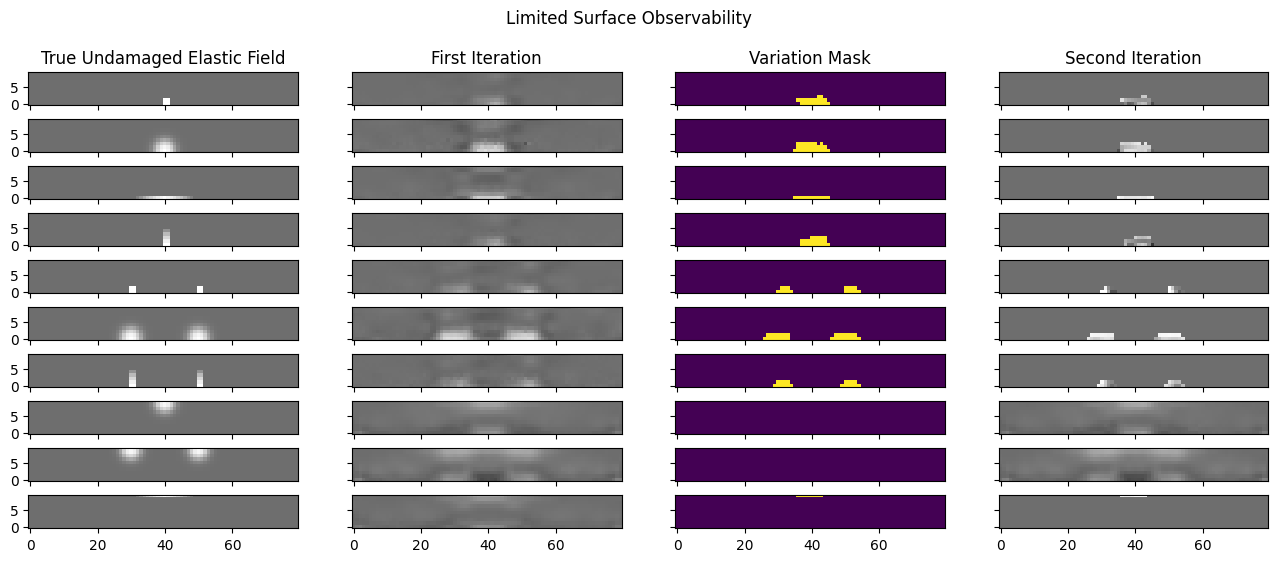

In [24]:
fig, axs = plt.subplots(10,4, sharex=True, sharey=True, figsize=(16,6))


fig.suptitle('Limited Surface Observability')

axs[0, 0].imshow(E_d, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
axs[0, 0].set_title('True Undamaged Elastic Field')

axs[1, 0].imshow(E_g, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[2, 0].imshow(E_h, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[3, 0].imshow(E_v, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[4, 0].imshow(E_d_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[5, 0].imshow(E_g_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[6, 0].imshow(E_v_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[7, 0].imshow(E_gt, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

axs[8, 0].imshow(E_gt_m, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


im = axs[9, 0].imshow(E_ht, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)
# axs[6, 0].set_title('True Damaged Elastic Field')
# divider = make_axes_locatable(axs[6, 0])
# cax = divider.append_axes("bottom", size="5%", pad=0.3)
# fig.colorbar(im, cax=cax, orientation='horizontal')

cases = ['d', 'g', 'h', 'v', 'dm', 'gm', 'vm', 'gt', 'gtm', 'ht']


directory_path = "."  # Replace with your desired directory path

files = os.listdir(directory_path)

filenames = [s for s in files if s.endswith('.json')]



Nx = 80
Ny = 10
n_particles = Nx * Ny


pattern = r"_(\d+)_(\d+)_"

def stable_regions(x, reference, n_percent=10, m=2):
    deviation = (x - reference) ** 2
    n_elements = int(len(deviation) * (n_percent / 100))
    
    # Get indices of the lowest n% deviations
    stable_indices = np.argsort(deviation)[:n_elements]
    
    # Compute the standard deviation of these stable elements
    stable_std = np.std(deviation[stable_indices])
    
    # Identify indices where deviation exceeds m times the stable standard deviation
    threshold = m * stable_std
    exceed_indices = np.where(deviation > threshold)[0]

    return stable_indices, stable_std, exceed_indices


for k, case in enumerate(cases):
    obs_cases = [
        'result_'+case+'_80_10_sensor.json',
    ]
    for l, obs_case in enumerate(obs_cases):
        with open(obs_case) as json_file:
            result = json.load(json_file)['E_hist'][-1]   
        E = np.zeros(n_particles)
        match = re.search(pattern, name)
        n_blocks_x = int(match.group(1))
        n_blocks_y = int(match.group(2))
        n_blocks = n_blocks_y * n_blocks_x
        block_nx = int(Nx / n_blocks_x)
        block_ny = int(Ny / n_blocks_y)

        for i in range(Nx):
            for j in range(Ny):
                block_index_x = i // block_nx
                block_index_y = j // block_ny
                E[j*Nx+i] = result[block_index_x + block_index_y * n_blocks_x]
        E = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
        
        axs[k, l + 1].imshow(E, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)

    stable, std, exceed = stable_regions(np.array(result), 1e4, n_percent=50, m=1e3)

    mask = np.zeros(n_particles)
    mask[exceed] = 100
    mask = einops.rearrange(mask, "(y x) -> x y", y=Ny).transpose()
    axs[k, l + 2].imshow(mask, origin='lower')
    if len(exceed) == 0:
        it2 = 'result_'+case+'_mask_80_10_sensor_start_10000.0.json'
        with open(it2) as json_file:
            result = json.load(json_file)['E_hist'][-1]
        E = np.array(result) 
        
    else:
        it2 = 'result_'+case+'_mask_80_10_sensor_start_100.0.json'
        with open(it2) as json_file:
            result = json.load(json_file)['E_hist'][-1] 
        E = np.zeros(n_particles) + 1e4
        E[exceed] = result
        

    E_rearrange = einops.rearrange(E, "(y x) -> x y", y=Ny).transpose()
    axs[k, l + 3].imshow(E_rearrange, origin='lower', cmap='Greys', vmin=1000, vmax = 15000)


axs[0, 1].set_title('First Iteration')
axs[0, 2].set_title('Variation Mask')
axs[0, 3].set_title('Second Iteration')
plt.show()


